In [5]:
pip install pgmpy

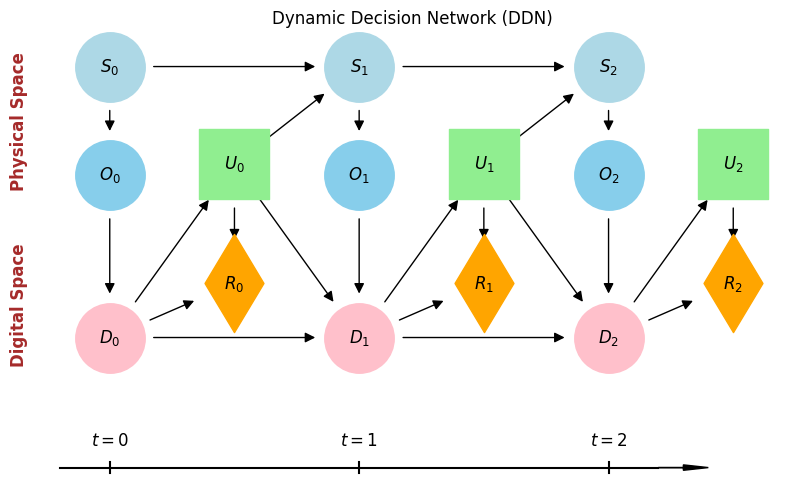

In [8]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork

# Define Bayesian Network Structure
model = BayesianNetwork([
    ("S_0", "S_1"), ("S_1", "S_2"),  # Physical state transitions
    ("S_0", "O_0"), ("S_1", "O_1"), ("S_2", "O_2"),  # Observations from states
    ("U_0", "S_1"), ("U_1", "S_2"),  # Actions affecting next states
    ("O_0", "D_0"), ("D_0", "U_0"), ("D_0", "R_0"), ("D_0", "D_1"),  # Digital space connections
    ("U_0", "R_0"), ("U_0", "D_1"),
    ("D_1", "U_1"), ("D_1", "R_1"), ("D_1", "D_2"),
    ("U_1", "R_1"), ("U_1", "D_2"), ("O_1", "D_1"), ("O_2", "D_2"),
    ("D_2", "U_2"), ("U_2", "R_2"),
    ("D_2", "R_2")
])

# Define node categories
physical_states = ["S_0", "S_1", "S_2"]
digital_states = ["D_0", "D_1", "D_2"]
observations = ["O_0", "O_1", "O_2"]
actions = ["U_0", "U_1", "U_2"]
rewards = ["R_0", "R_1", "R_2"]

# Define LaTeX-style labels for subscripts
latex_labels = {node: f"${node[0]}_{{{node[2]}}}$" for node in model.nodes()}

# Define structured layout for the nodes
pos = {
    "S_0": (0, 3), "S_1": (1, 3), "S_2": (2, 3),  # Physical Space
    "O_0": (0, 2), "O_1": (1, 2), "O_2": (2, 2),  # Observations
   "U_0": (0.5, 2.1), "U_1": (1.5, 2.1), "U_2": (2.5, 2.1),  # Middle: Actions
    "R_0": (0.5, 1), "R_1": (1.5, 1), "R_2": (2.5, 1),  # Centered Rewards
    "D_0": (0, 0.5), "D_1": (1, 0.5), "D_2": (2, 0.5),  # Digital Space
}

# Create the graph using NetworkX
graph = nx.DiGraph()
graph.add_edges_from(model.edges())

# Draw figure
plt.figure(figsize=(10, 6))

# Draw different node types separately with correct shapes
nx.draw_networkx_nodes(graph, pos, nodelist=physical_states, node_shape='o', node_size=2500, node_color='lightblue')
nx.draw_networkx_nodes(graph, pos, nodelist=observations, node_shape='o', node_size=2500, node_color='skyblue')
nx.draw_networkx_nodes(graph, pos, nodelist=actions, node_shape='s', node_size=2500, node_color='lightgreen')
nx.draw_networkx_nodes(graph, pos, nodelist=digital_states, node_shape='o', node_size=2500, node_color='pink')
nx.draw_networkx_nodes(graph, pos, nodelist=rewards, node_shape='d', node_size=2500, node_color='orange')

# Draw edges with arrowheads
nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='-|>', arrowsize=15, edge_color='black', width=1, node_size=4000)

# Add LaTeX labels for subscripts
nx.draw_networkx_labels(graph, pos, labels=latex_labels, font_size=12, font_weight="bold")

# Add text labels for "Physical Space" and "Digital Space"
plt.text(-0.4, 2.5, "Physical Space", fontsize=12, fontweight="bold", rotation=90, verticalalignment='center', color="brown")
plt.text(-0.4, 0.8, "Digital Space", fontsize=12, fontweight="bold", rotation=90, verticalalignment='center', color="brown")

# Add time labels at the bottom of the graph
plt.text(0, -0.5, r"$t=0$", fontsize=12, fontstyle="oblique", ha="center")
plt.text(1, -0.5, r"$t=1$", fontsize=12, fontstyle="oblique", ha="center")
plt.text(2, -0.5, r"$t=2$", fontsize=12, fontstyle="oblique", ha="center")

# Add timeline (horizontal line)
plt.plot([-0.2, 2.2], [-0.7, -0.7], color="black")  # Main timeline
plt.plot([0, 0], [-0.75, -0.65], color="black")  # Tick mark for t=0
plt.plot([1, 1], [-0.75, -0.65], color="black")  # Tick mark for t=1
plt.plot([2, 2], [-0.75, -0.65], color="black")  # Tick mark for t=2
plt.arrow(2.2, -0.7, 0.1, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')  # Arrow at end of timeline

# Remove axis
plt.axis('off')

# Display the graph
plt.title("Dynamic Decision Network (DDN)")
plt.show()


In [10]:
# Import required libraries
import numpy as np
from pgmpy.factors.discrete import TabularCPD

# Function to Combine CPDs for Multi-Variable Dependencies
def get_combined_cpd(cpd_1, cpd_2):
    """
    Combines two CPDs when a variable is conditioned on multiple parents.
    :param cpd_1: First CPD (e.g., P(D_t | D_t-1))
    :param cpd_2: Second CPD (e.g., P(D_t | U_t-1))
    :return: Combined CPD for P(D_t | D_t-1, U_t-1)
    """
    n_states = cpd_1.shape[0]
    card_1 = cpd_1.shape[1]
    card_2 = cpd_2.shape[1]
    combined_cpd = np.zeros((n_states, card_1 * card_2))

    for i in range(n_states):
        for j in range(card_1):
            for k in range(card_2):
                combined_cpd[i, j *n_states + k] = cpd_1[i, j] * cpd_2[i, k]

    # Normalize CPD so columns sum to 1
    combined_cpd /= combined_cpd.sum(axis=0)
    return combined_cpd


# CPD for Initial State S_0 (Prior Distribution)
cpd_S0 = TabularCPD(variable="S_0", variable_card=3, values=[
    [0.5],
    [0.3],
    [0.2]
])

# CPDs for State Transitions P(S_t | S_t-1, U_t-1))
cpd_S1 = TabularCPD(variable="S_1", variable_card=3, values=[
    [0.8, 0.1, 0.2, 0.7, 0.2, 0.1],
    [0.15, 0.7, 0.3, 0.2, 0.6, 0.2],
    [0.05, 0.2, 0.5, 0.1, 0.2, 0.7]
], evidence=["S_0", "U_0"], evidence_card=[3, 2])

cpd_S2 = TabularCPD(variable="S_2", variable_card=3, values=[
    [0.8, 0.1, 0.2, 0.7, 0.2, 0.1],
    [0.15, 0.7, 0.3, 0.2, 0.6, 0.2],
    [0.05, 0.2, 0.5, 0.1, 0.2, 0.7]
], evidence=["S_1", "U_1"], evidence_card=[3, 2])

# CPDs for Observations
cpd_O0 = TabularCPD(variable="O_0", variable_card=3, values=[
    [0.9, 0.2, 0.1],
    [0.05, 0.6, 0.2],
    [0.05, 0.2, 0.7]
], evidence=["S_0"], evidence_card=[3])

cpd_O1 = TabularCPD(variable="O_1", variable_card=3, values=[
    [0.9, 0.2, 0.1],
    [0.05, 0.6, 0.2],
    [0.05, 0.2, 0.7]
], evidence=["S_1"], evidence_card=[3])

cpd_O2 = TabularCPD(variable="O_2", variable_card=3, values=[
    [0.9, 0.2, 0.1],
    [0.05, 0.6, 0.2],
    [0.05, 0.2, 0.7]
], evidence=["S_2"], evidence_card=[3])

# CPDs for Digital State Transitions P(D_t | D_t-1, U_t-1)
cpd_D0 = TabularCPD(variable="D_0", variable_card=3, values=[
    [0.85, 0.2, 0.1],
    [0.10, 0.6, 0.2],
    [0.05, 0.2, 0.7]
], evidence=["O_0"], evidence_card=[3])

cpd_D1 = TabularCPD(variable="D_1", variable_card=3, values=get_combined_cpd(
    np.array([[0.85, 0.2, 0.1], [0.10, 0.6, 0.2], [0.05, 0.2, 0.7]]),
    np.array([[0.8, 0.1, 0.05], [0.15, 0.7, 0.2], [0.05, 0.2, 0.75]])
), evidence=["D_0", "U_0"], evidence_card=[3, 3])

cpd_D2 = TabularCPD(variable="D_2", variable_card=3, values=get_combined_cpd(
    np.array([[0.85, 0.2, 0.1], [0.10, 0.6, 0.2], [0.05, 0.2, 0.7]]),
    np.array([[0.8, 0.1, 0.05], [0.15, 0.7, 0.2], [0.05, 0.2, 0.75]])
), evidence=["D_1", "U_1"], evidence_card=[3, 3])

#  Reward P(R_t | D_t, U_t)
cpd_R0 = TabularCPD(variable="R_0", variable_card=3, values=[
    [0.9, 0.1, 0.2, 0.7, 0.2, 0.1],
    [0.05, 0.7, 0.5, 0.2, 0.6, 0.2],
    [0.05, 0.2, 0.3, 0.1, 0.2, 0.7]
], evidence=["D_0", "U_0"], evidence_card=[3, 2])


# Add CPDs
model.add_cpds(cpd_S0, cpd_S1, cpd_S2, cpd_O0, cpd_O1, cpd_O2, cpd_D0, cpd_D1, cpd_D2, cpd_R0)



# Print CPDs
for cpd in model.get_cpds():
    print(cpd)

+--------+-----+
| S_0(0) | 0.5 |
+--------+-----+
| S_0(1) | 0.3 |
+--------+-----+
| S_0(2) | 0.2 |
+--------+-----+
+--------+--------+--------+--------+--------+--------+--------+
| S_0    | S_0(0) | S_0(0) | S_0(1) | S_0(1) | S_0(2) | S_0(2) |
+--------+--------+--------+--------+--------+--------+--------+
| U_0    | U_0(0) | U_0(1) | U_0(0) | U_0(1) | U_0(0) | U_0(1) |
+--------+--------+--------+--------+--------+--------+--------+
| S_1(0) | 0.8    | 0.1    | 0.2    | 0.7    | 0.2    | 0.1    |
+--------+--------+--------+--------+--------+--------+--------+
| S_1(1) | 0.15   | 0.7    | 0.3    | 0.2    | 0.6    | 0.2    |
+--------+--------+--------+--------+--------+--------+--------+
| S_1(2) | 0.05   | 0.2    | 0.5    | 0.1    | 0.2    | 0.7    |
+--------+--------+--------+--------+--------+--------+--------+
+--------+--------+--------+--------+--------+--------+--------+
| S_1    | S_1(0) | S_1(0) | S_1(1) | S_1(1) | S_1(2) | S_1(2) |
+--------+--------+--------+--------